In [1]:
%cd ../..

c:\Users\tacke\OneDrive\Documents\GitHub\Modern-Time-Series-Forecasting-with-Python-2E-1


In [9]:
import os
import shutil

import joblib
import numpy as np
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.templates.default = "plotly_white"

from pathlib import Path

from tqdm.autonotebook import tqdm
from IPython.display import display, HTML
# %load_ext autoreload
# %autoreload 2
np.random.seed(42)
tqdm.pandas()

from ray import tune
from statsforecast import StatsForecast
from neuralforecast import NeuralForecast
from neuralforecast.auto import AutoNHITS, AutoLSTM
from neuralforecast.losses.pytorch import MQLoss

import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("whitegrid")

In [6]:
preprocessed = Path("data/london_smart_meters/preprocessed")
output = Path("data/london_smart_meters/output")
try:
    #Reading the missing value imputed and train test split data
    train_df = pd.read_parquet(preprocessed/"selected_blocks_train_missing_imputed_feature_engg.parquet")
    # Read in the Validation dataset as test_df so that we predict on it
    test_df = pd.read_parquet(preprocessed/"selected_blocks_val_missing_imputed_feature_engg.parquet")
    # test_df = pd.read_parquet(preprocessed/"selected_blocks_test_missing_imputed_feature_engg.parquet")
except FileNotFoundError:
    display(HTML("""
    <div class="alert alert-block alert-warning">
    <b>Warning!</b> File not found. Please make sure you have run 01-Feature Engineering.ipynb in Chapter06
    </div>
    """))

In [4]:
train_df.head()

,timestamp,LCLid,energy_consumption,frequency,series_length,stdorToU,Acorn,Acorn_grouped,file,holidays,...,timestamp_Minute_sin_1,timestamp_Minute_sin_2,timestamp_Minute_sin_3,timestamp_Minute_sin_4,timestamp_Minute_sin_5,timestamp_Minute_cos_1,timestamp_Minute_cos_2,timestamp_Minute_cos_3,timestamp_Minute_cos_4,timestamp_Minute_cos_5
0,2012-01-01 00:00:00,MAC000061,0.114,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
1,2012-01-01 00:30:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
2,2012-01-01 01:00:00,MAC000061,0.113,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0
3,2012-01-01 01:30:00,MAC000061,0.098,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,5.665539e-16,-1.133108e-15,2.143751e-15,-2.266215e-15,6.123234e-16,-1.0,1.0,-1.0,1.0,-1.0
4,2012-01-01 02:00:00,MAC000061,0.060,30min,37872,Std,ACORN-Q,Adversity,block_96,NO_HOLIDAY,...,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,1.0,1.0,1.0,1.0,1.0


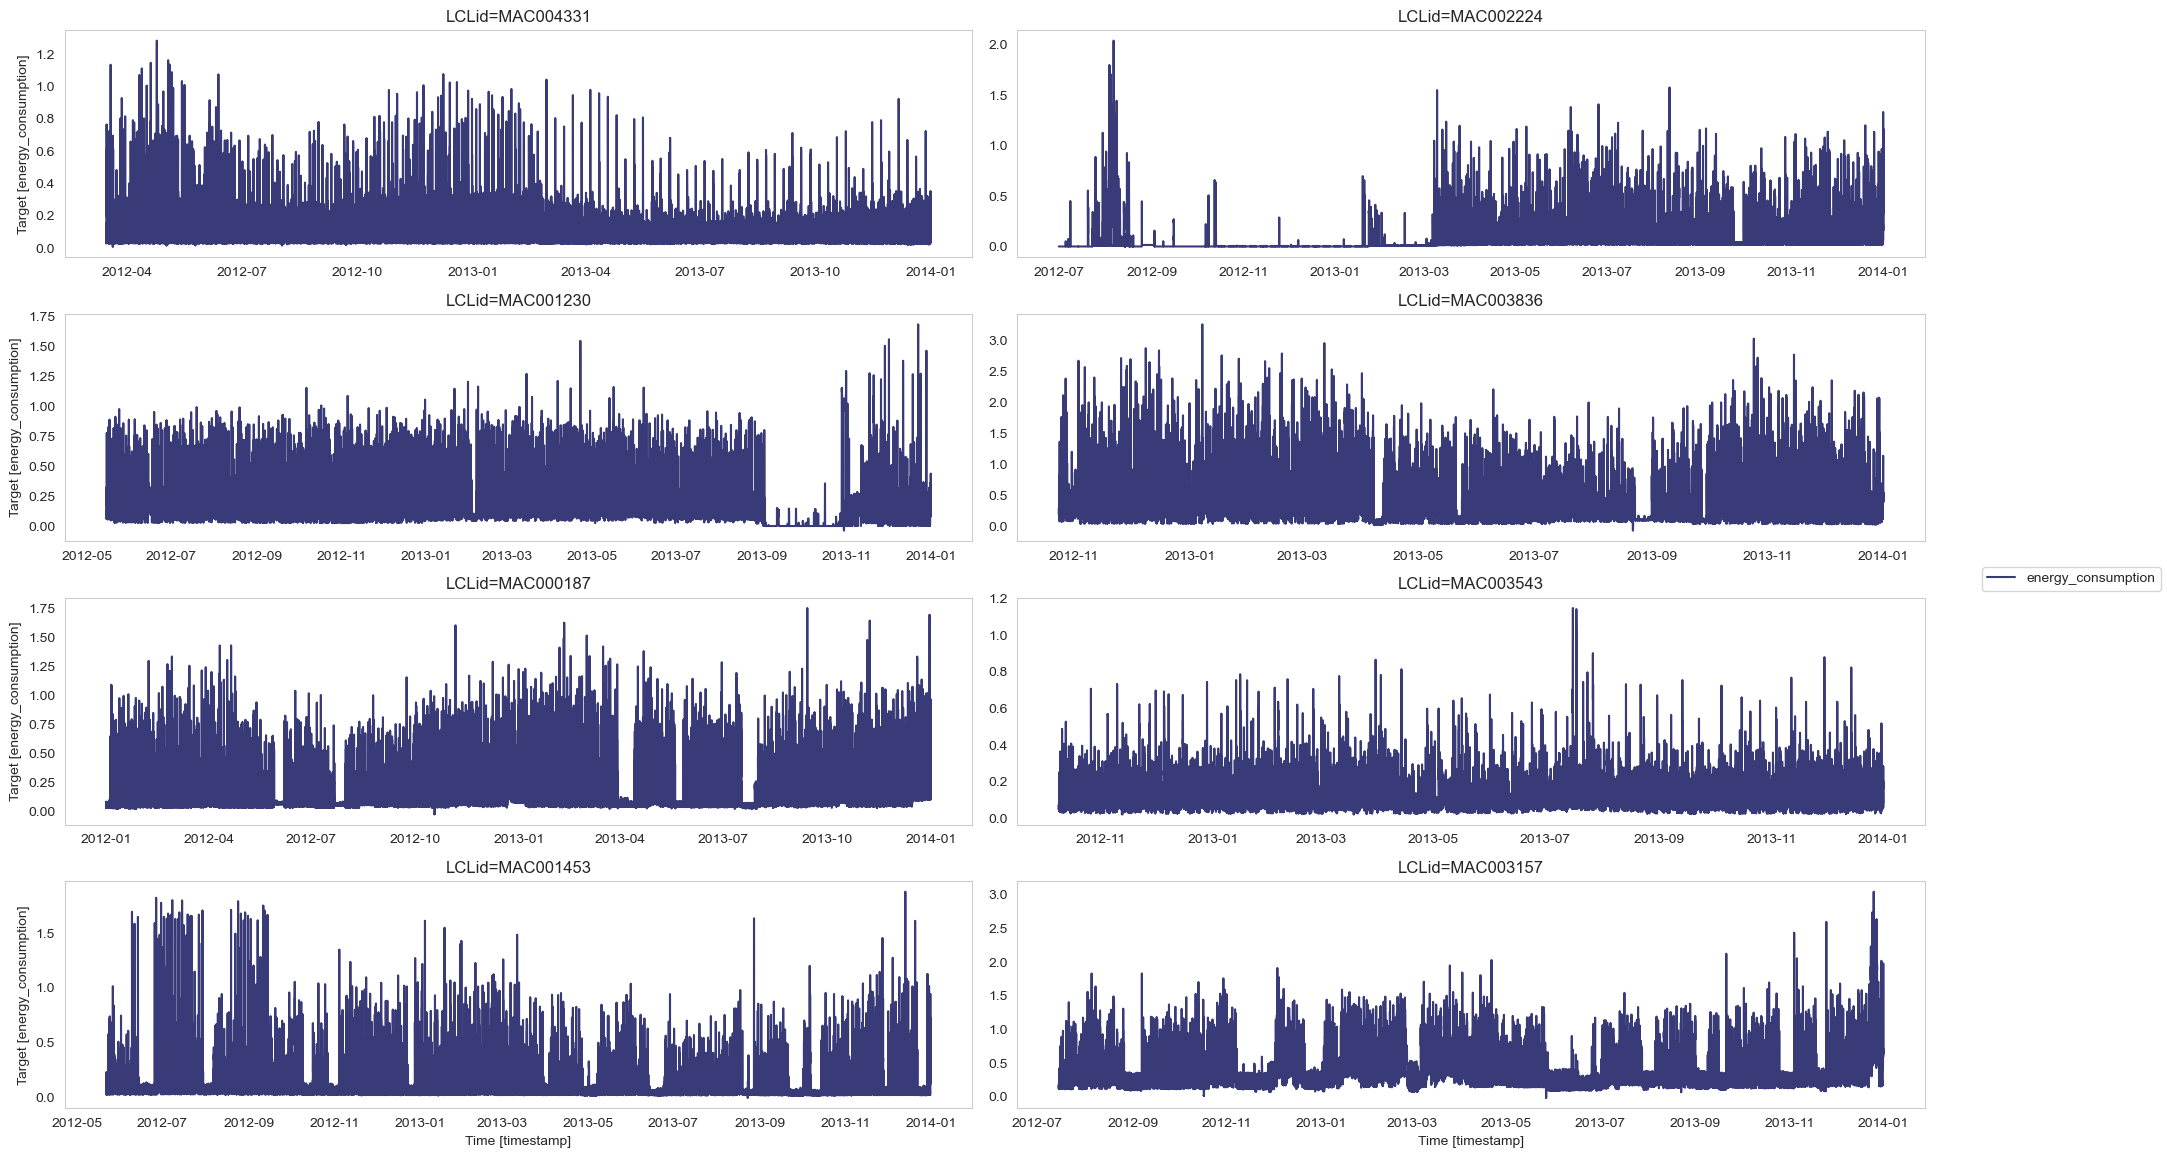

In [10]:
StatsForecast.plot(train_df, engine='matplotlib', id_col='LCLid',time_col= 'timestamp', target_col='energy_consumption')